# **Ejercicios 3 y 4 - Modelado, métricas y conclusiones**

Este es el notebook que contiene los ejercicios 3 y 4 de la práctica. Pienso que tiene más sentido ir comprobando las métricas de cada modelo a medida que lo vayamos diseñando, no en un notebook independiente.

Al final del notebook aportaremos unas conclusiones sobre los resultados de los modelos.

Los distintos modelos incluyen en algunos casos la columna de 'text', otros la de 'title', y finalmente la combinación de ambas. Por otro lado, en ocasiones hemos utilizado una clasificación binaria (0/1), y en otros hemos utilizado los ratings de 1 a 5.

He utilizado tanto modelos de machine learning como de deep learning.

He utilizado para los modelos un solo dataset, porque probar los tres se haría interminable.

El contenido del notebook se divide en los siguientes apartados:

- Funciones utilizadas
- Carga de datasets
- Determinación de la columna del sentimiento binario (0/1)
- **Modelos de machine learning**
    - Log Regression con columna 'text' y clasificación binaria
    - Log Regression con columna 'text' y clasificación 1 a 5
    - Random Forest con columna 'text' y clasificación 1 a 5
    - Log Regression con columna 'title' y clasificación binaria
    - Log Regression con columnas 'text' y 'title' y clasificación binaria
    - Log Regression con columnas 'text' y 'title' y clasificación 1 a 5

- **Modelos de deep learning**
    - Embeddings estimados con columna 'text' y clasificación binaria
    - Embeddings estimados con columna 'title' y clasificación binaria
    - Embeddings estimados con columna 'text' y 'title' y clasificación binaria

- **Modelo preentrenado**
    - Modelo BERT de clasificación de sentimientos

- **Conclusiones**

Comenzamos cargando las librerías necesarias, tanto las utilizadas en la parte de machine learning como las que usaremos en deep learning, incluyendo la instalación de gensim.

In [ ]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, RocCurveDisplay, auc

import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 33.2 MB/s eta 0:00:00


In [ ]:
import gensim
import multiprocessing as mp

import requests
import numpy as np

%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU, Bidirectional, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import get_file

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Funciones utilizadas

Listamos a continuación las funciones que hemos definido en el resto del notebook. No son demasiadas, especialmente en la parte de machine learning, con las que comenzamos.

Función para crear la columna de sentimiento binario (0/1) en funcion de la columna 'rating'.

In [ ]:
def label_sentiment(row):
    if int(row['rating']) < 3:
        return 1
    else:
        return 0

Otra función que tenemos es la 'curva_roc', que dibuja la curva ROC, nada espectacular.

In [ ]:
def curva_roc(model, X_test, y_test):
    display = RocCurveDisplay.from_estimator(model, X_test, y_test)
    #display.plot()
    plt.show()

Dentro de la parte de deep learning, definimos tres funciones para crear nuestros embeddings, comenzando con el tokenizer...

In [ ]:
def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

... siguiendo con el word2vec, que instancia el modelo, crea el vocabulario y hace el entrenamiento del modelo.

In [ ]:
def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df]
    w2v_model = gensim.models.word2vec.Word2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.key_to_index.keys() # Corrected line
    vocab_size = len(words)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

A continuación tenemos la función que genera la capa de embedding.

In [ ]:
def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )



Tenemos la función que implementa el modelo preentrenado BERT.

In [ ]:
def predict_sentiment_batch(texts, model, tokenizer, batch_size=16):
    """Predict sentiment in batches with progress bar"""
    predictions = []

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Process in batches with progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Move to GPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_predictions.cpu().tolist())

    return predictions

Finalmente, tenemos la función que traduce la clasificación del modelo BERT al sistema de ratings implementado en los datasets.

In [ ]:
def convert_to_binary(predictions):
    binary_predictions = []
    for pred in predictions:
        if pred in [0, 1]:  # 1-2 stars (assuming 0-indexed: 0=1 star, 1=2 stars)
            binary_predictions.append(1)  #
        elif pred in [2, 3, 4]:  #
            binary_predictions.append(0)  #
       # else:  # 3 stars (2=3 stars)
         #   binary_predictions.append(1)  # Or you can exclude these
    return binary_predictions

## Carga de datasets

Ahora cargamos los tres datasets ya preprocesados en el notebook anterior. De todas formas, para la creación de modelos, solo utiizaremos uno de ellos. Casteamos de nuevo las columnas de 'text' y 'title' a string para evitar problemas.

In [ ]:
dtype = {'text': str, 'title': str}

df_beauty_prep = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_beauty_prep.csv', dtype = dtype, na_values = '')
df_health_prep = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_health_prep.csv', dtype = dtype, na_values = '')
df_digital_prep = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_digital_prep.csv', dtype = dtype, na_values = '')

In [ ]:
df_beauty_prep['title_lemmatized'] = df_beauty_prep['title_lemmatized'].astype(str)
df_beauty_prep['text_lemmatized'] = df_beauty_prep['text_lemmatized'].astype(str)
df_health_prep['title_lemmatized'] = df_health_prep['title_lemmatized'].astype(str)
df_health_prep['text_lemmatized'] = df_health_prep['text_lemmatized'].astype(str)
df_digital_prep['title_lemmatized'] = df_digital_prep['title_lemmatized'].astype(str)
df_digital_prep['text_lemmatized'] = df_digital_prep['text_lemmatized'].astype(str)

In [ ]:
df_beauty_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title_lemmatized  30000 non-null  object 
 1   text_lemmatized   30000 non-null  object 
 2   rating            30000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 703.3+ KB


In [ ]:
df_beauty_prep.head()

,title_lemmatized,text_lemmatized,rating
0,look hook body wash holder,look hook body wash holder long time wish litt...,3.0
1,good shampoo date,nourish shampoo contain natural ingredient lot...,5.0
2,waste money,work remotely husband attempt use clean dry sk...,1.0
3,set spray,product effective set makeup actually cause sm...,3.0
4,product wonderful issue,deep steep vanilla peppermint wonderful fragra...,4.0


## Determinación de la columna del sentimiento binario (0/1)

Ahora debemos crear la columna binaria de sentimiento, y para ello definimos la función que hace diferencia de si el rating es mayor o menor de 3.

In [ ]:
def label_sentiment(row):
    if int(row['rating']) < 3:
        return 1
    else:
        return 0

Ahora creamos la columna de sentimiento binario 'sentiment_label' en el dataset de belleza, que será el que usemos para modelar.

In [ ]:
df_beauty_prep['sentiment_label'] = df_beauty_prep.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
df_beauty_prep.head()

,title_lemmatized,text_lemmatized,rating,sentiment_label
0,look hook body wash holder,look hook body wash holder long time wish litt...,3.0,0
1,good shampoo date,nourish shampoo contain natural ingredient lot...,5.0,0
2,waste money,work remotely husband attempt use clean dry sk...,1.0,1
3,set spray,product effective set makeup actually cause sm...,3.0,0
4,product wonderful issue,deep steep vanilla peppermint wonderful fragra...,4.0,0


Vemos que, como era de esperar, hay un desbalanceo hacia el sentimiento '0', que corresponde a los ratings 4 y 5, pero tampoco es escandaloso.

In [ ]:
df_beauty_prep['sentiment_label'].value_counts()

,count
sentiment_label,
0,18076
1,11924


Creamos la columna de sentimiento en los otros dos datasets.

In [ ]:
df_health_prep['sentiment_label'] = df_health_prep.apply(lambda row: label_sentiment(row), axis=1)
df_digital_prep['sentiment_label'] = df_digital_prep.apply(lambda row: label_sentiment(row), axis=1)

En el dataset de salud el desbalanceo es similar al de belleza, pero en el de música digital es algo mayor.

In [ ]:
df_health_prep['sentiment_label'].value_counts()

,count
sentiment_label,
0,18661
1,11339


In [ ]:
df_digital_prep['sentiment_label'].value_counts()

,count
sentiment_label,
0,22499
1,7501


# **Modelos de Machine Learning**

Pasamos a modelar el dataser de belleza, 'df_beauty_prep', tanto en el caso de la columna 'text' como 'title' y ambas a la vez, y con el sentimiento binario o el rating de 1 a 5.

## Log Regression con columna 'text' y clasificación binaria

Vamos a modelizar el dataset de belleza en su columna 'text' y con clasificacion binaria (0/1).

Comenzamos dividiendo el dataset entre train y test, ignorando las columnas que no utilizaremos en esta ocasión.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_beauty_prep['text_lemmatized'],
    df_beauty_prep['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Comprobamos que tenemos las columnas que queremos.

In [ ]:
X_train.head()

,text_lemmatized
21177,make hair soft
23942,cheap having pay premium high end salon produc...
1247,do not hold hair clip thin hair work
23622,great price professional packaging come free g...
28454,take three coat color coverage take long time ...


In [ ]:
y_train.head()

,sentiment_label
21177,0
23942,0
1247,0
23622,0
28454,1


Vamos a utilizar para vectorizar el texto la librería de TfidfVectorizer(), que no tiene en cuenta el contexto, pero que al menos si informa de la relevancia de cada palabra, y que es normalmente utilizado en problemas de Machine Learning.

Instanciamos el objeto (modelo) de TfidfVectorizer con un máximo de 2.500 palabras, por lo que habrá ciertas pérdidas, ya que el total de ellas en el dataset es superior, pero hay que tener en cuenta también el coste en computación.

También llevamos a cabo el entrenamiento del modelo con el dataset de train que hemos definido antes.

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

Podemos comprobar con el vocabulario generado que contamos con 2.500 palabras

In [ ]:
print(list(cv.vocabulary_.items())[:20])

[('make', np.int64(1262)), ('hair', np.int64(965)), ('soft', np.int64(2010)), ('cheap', np.int64(338)), ('having', np.int64(991)), ('pay', np.int64(1524)), ('premium', np.int64(1628)), ('high', np.int64(1020)), ('end', np.int64(697)), ('salon', np.int64(1826)), ('product', np.int64(1651)), ('smell', np.int64(1994)), ('great', np.int64(943)), ('overpower', np.int64(1480)), ('do', np.int64(625)), ('not', np.int64(1421)), ('hold', np.int64(1027)), ('clip', np.int64(376)), ('thin', np.int64(2215)), ('work', np.int64(2465))]


In [ ]:
print(len(cv.vocabulary_))

2500


Ahora aplicamos en modelo a los datasets de train y test, y comprobamos que tenemos matrices de 2.500 columnas, el número de palabras en nuestro diccionario.

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [ ]:
X_train_

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 277243 stored elements and shape (22500, 2500)>

Podemos hacer una prueba para ver como funciona el modelo en la práctica. Pasamos así una lista de palabras, que tienen a priori que ver con la belleza.

In [ ]:
words_beauty = [
    'product',
    'health',
    'skin',
    'hair',
    'color',
    'money',
    'work',
    'look',
    'nails',
    'eyes'
]

Los coefcientes IDF tienen distintos valores, pero palabras como 'nails' o 'eyes' se han quedado fuera. Curioso.

In [ ]:
vocab_idf = dict(zip(cv.get_feature_names_out(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_beauty:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
product             2.774
health              7.763
skin                3.845
hair                2.845
color               3.564
money               4.025
work                2.894
look                3.244
nails               OOV                 
eyes                OOV                 


Ya que estamos aquí podemos ver qué palabras son más relevantes para nuestra clasificación binaria, que siguen saliendo positivas como 'love' y 'great', o negativas como 'waste'.

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3230920180.py:15: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('$\chi^2$', fontsize=26)
/tmp/ipython-input-3230920180.py:17: SyntaxWarning: invalid escape sequence '\c'
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


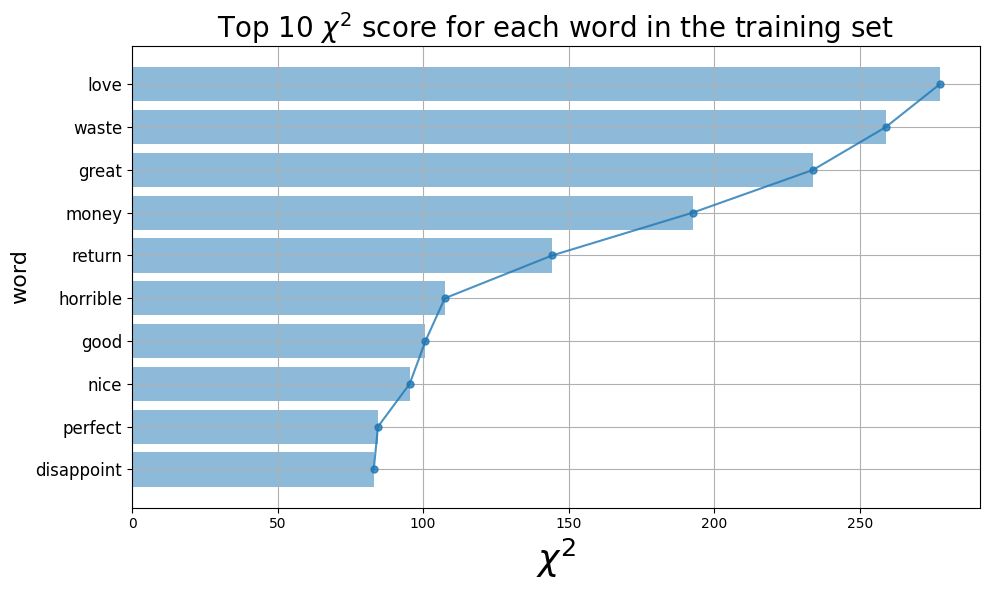

In [ ]:
# Compute the chi-squared score for each word in the training set and show the values
i = 10

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(10, 6))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Por fin, pasamos a la modelización, para la que utilizamos la regresión logística, para la que introducimos varios coeficientes C, que controlan el grado de regularización, siendo C=1 el valor por defecto.

Lo cierto es que obtenemos unos resultados bastante buenos, pues en el dataset de test, el accuracy es de 0,80, para valores de C de 0,5 y 1.

In [ ]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6386666666666667
Accuracy for C=0.05: 0.7516
Accuracy for C=0.25: 0.7916
Accuracy for C=0.5: 0.7994666666666667
Accuracy for C=1: 0.8
Accuracy for C=10: 0.7882666666666667
Accuracy for C=100: 0.7813333333333333
Accuracy for C=1000: 0.7792
Accuracy for C=10000: 0.7794666666666666


En datsets desbalanceados es bueno tener en cuenta otras métricas, como el recall, para ver si el modelo reconoce la clase minoritaria, y lo cierto es que tenemos un recall más o menos razonable de la clase del 0.69. Estos datos son para el C de 0.5.

In [ ]:
c_params = [0.5]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

Accuracy for C=0.5: 0.7994666666666667


In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[3862  539]
 [ 965 2134]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      4401
           1       0.80      0.69      0.74      3099

    accuracy                           0.80      7500
   macro avg       0.80      0.78      0.79      7500
weighted avg       0.80      0.80      0.80      7500

Accuracy score:0.7994666666666667


In [ ]:
def curva_roc(model, X_test, y_test):
    display = RocCurveDisplay.from_estimator(model, X_test, y_test)
    #display.plot()
    plt.show()

Podemos evaluar el clasificador que hemos definido también con la curva ROC, que calcula los recalls de la clase 1 a medida que variamos el threshold de decisión del clasificador. Teoricamente, un clasificador perfecto tendría una gráfica vertical en x=0, y horizontal después. El area under curve óptimo sería 1, y obtenemos 0.88, lo cual es bastante bueno.

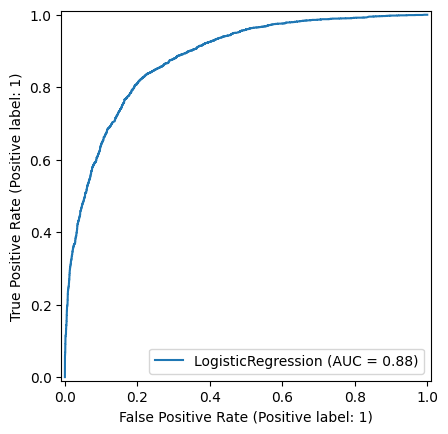

In [ ]:
curva_roc(lr, X_test_, y_test)

## Log Regression con columna 'text' y clasificación 1 a 5

La clasificación binaria no ha ido mal, pero veamos el caso de la clasificación de rating 1 a 5.

In [ ]:
df_beauty_prep.head()

,title_lemmatized,text_lemmatized,rating,sentiment_label
0,look hook body wash holder,look hook body wash holder long time wish litt...,3.0,0
1,good shampoo date,nourish shampoo contain natural ingredient lot...,5.0,0
2,waste money,work remotely husband attempt use clean dry sk...,1.0,1
3,set spray,product effective set makeup actually cause sm...,3.0,0
4,product wonderful issue,deep steep vanilla peppermint wonderful fragra...,4.0,0


Lo cierto es que, aunque quizás no sea estrictamente necesario, prefiero crear una columna nueva, que sea la del rating casteado a string.

In [ ]:
df_beauty_prep['rating_str'] = df_beauty_prep['rating'].astype(str)

In [ ]:
df_beauty_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title_lemmatized  30000 non-null  object 
 1   text_lemmatized   30000 non-null  object 
 2   rating            30000 non-null  float64
 3   sentiment_label   30000 non-null  int64  
 4   rating_str        30000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


Hacemos un value_counts de esta columna, que muestra un quizás inevitable desbalanceo, aunque no excesivo.

In [ ]:
df_beauty_prep['rating_str'].value_counts()

,count
rating_str,
1.0,8384
5.0,6710
4.0,6547
3.0,4819
2.0,3540


Ahora pasamos a hacer el train test split, con la columna 'text', y ahora la columna de 'rating_str' que hemos defino antes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_beauty_prep['text_lemmatized'],
    df_beauty_prep['rating_str'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Pasamos a hacer de nuevo el proceso de vectorización, con los mismos parámetros que en el modelado anterior. Hacemos la instanciación y el entrenamiento.

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

Transformamos los datasets de train y test con la vectorización ya entrenada.

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Y finalmente pasamos a la clasificación multiclase con distintos coeficientes C.

Lo cierto es que obtenemos accuracies en el entorno al 51%, muy inferiores que en el caso de la binaria, lo cual es lógico. Ahora el C óptimo está en 0.4.

In [ ]:
c_params = [0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 1]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.25: 0.5184
Accuracy for C=0.4: 0.5137333333333334
Accuracy for C=0.5: 0.5121333333333333
Accuracy for C=0.6: 0.5105333333333333
Accuracy for C=0.7: 0.5088
Accuracy for C=0.8: 0.5094666666666666
Accuracy for C=1: 0.5094666666666666


Calculamos el modelo con C=0.4, para ver las métricas. Ya conocemos que el accuracy es 0.514.

In [ ]:
train_acc = list()
test_acc = list()

lr = LogisticRegression(C=0.4, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
test_predict = lr.predict(X_test_)

print ("Accuracy for C={}: {}".format(0.4, accuracy_score(y_test, test_predict)))

train_acc.append(accuracy_score(y_train, train_predict))
test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.4: 0.5137333333333334


Las métricas son interesantes. Quizás lo más exclerazador es que los recall son muy variables: muy buenos en el caso de rating 1 y 5, siendo menores en el resto.

Lo que creo que ocurre es que el vocabulario en los ratings extremos uno pensaría que es muy explícito, mientras que no es así en el caso de los ratings intermedios. Cuesta a priori diferenciar, por ejemplo, un rating 2 o 3, mientras que las opiniones extremas son mucho más fáciles de discernir.

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[1817   30  124  103   84]
 [ 576   13  141  132   79]
 [ 404   14  253  350  140]
 [ 254    7  187  739  486]
 [ 170    3   41  322 1031]]

Classification report:
              precision    recall  f1-score   support

         1.0       0.56      0.84      0.68      2158
         2.0       0.19      0.01      0.03       941
         3.0       0.34      0.22      0.27      1161
         4.0       0.45      0.44      0.45      1673
         5.0       0.57      0.66      0.61      1567

    accuracy                           0.51      7500
   macro avg       0.42      0.43      0.40      7500
weighted avg       0.46      0.51      0.47      7500

Accuracy score:0.5137333333333334


## Random Forest con columna 'text' y clasificación 1 a 5

No hay que darse por vencidos, ya que podemos probar otro clasificador, a ver si mejoramos a la regresión logística. Probamos pues el Random Forest.

Ya que tenemos 2.500 columnas, intentamos optimizar el modelo con profundidades importantes, hasta de 90. utilizamos en esta ocasión GridSearch. Parece que obtenemos un accuracy máximo en el entorno de 0.49 en el cross validation con una profundidad de 70. No tiene buena pinta.

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................................max_depth=10; total time=   2.2s
[CV] END .......................................max_depth=10; total time=   1.8s
[CV] END .......................................max_depth=10; total time=   1.8s
[CV] END .......................................max_depth=20; total time=   5.8s
[CV] END .......................................max_depth=20; total time=   5.2s
[CV] END .......................................max_depth=20; total time=   4.7s
[CV] END .......................................max_depth=30; total time=  10.7s
[CV] END .......................................max_depth=30; total time=  10.5s
[CV] END .......................................max_depth=30; total time=   9.0s
[CV] END .......................................max_depth=40; total time=  18.6s
[CV] END .......................................max_depth=40; total time=  15.9s
[CV] END .......................................m

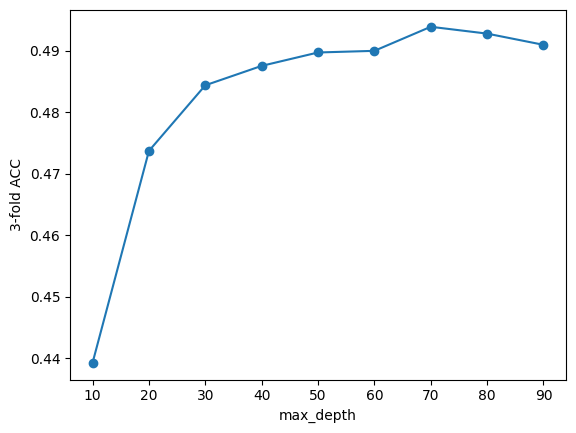

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

maxDepth = range(10, 100, 10)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestClassifier(random_state=0, n_estimators=150, max_features='sqrt'), param_grid=tuned_parameters, cv=3, verbose=2)
grid.fit(X_train_, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('3-fold ACC')

plt.show()

Lo cierto es que cuando probamos una profundidad de 70, estamos en pleno territorio de overfitting, por lo que reducimos la profudidad hasta obtener una diferencia en el accuracy de train y test aceptable, que es 20. El accuracy en test es 0.48, menor pues que en el caso de la regresión logística.

In [ ]:
maxDepthOptimo = 20

randomForest = RandomForestClassifier(max_depth = maxDepthOptimo, n_estimators = 150, max_features='sqrt').fit(X_train_, y_train)

print("Train: ",randomForest.score(X_train_, y_train))
print("Test: ",randomForest.score(X_test_, y_test))

Train:  0.5756444444444444
Test:  0.4768


In [ ]:
test_predict = randomForest.predict(X_test_)

Podemos ver las métricas en este caso, y lo cierto es que presenta los mismos rasgos que con regresión logística: recalls altos en los ratings 1 y 5, y muy bajos en el resto, incluso cero con el rating de 2, pienso que por las mismas causas. No es pues random forest una alternativa clara a la regresión logística.

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[1990    0    6   88   74]
 [ 728    0    9  116   88]
 [ 678    0   40  274  169]
 [ 583    0   11  569  510]
 [ 362    0    2  226  977]]

Classification report:
              precision    recall  f1-score   support

         1.0       0.46      0.92      0.61      2158
         2.0       0.00      0.00      0.00       941
         3.0       0.59      0.03      0.07      1161
         4.0       0.45      0.34      0.39      1673
         5.0       0.54      0.62      0.58      1567

    accuracy                           0.48      7500
   macro avg       0.41      0.38      0.33      7500
weighted avg       0.43      0.48      0.39      7500

Accuracy score:0.4768


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Log Regression con columna 'title' y clasificación binaria

Hasta ahora hemos trabajado con la columna 'text', es decir, con el texto de la propia review. Con todo, podemos ver si el título de la review puede aportar un mínimo de valor a nuestra clasificación. Por ello, en este apartado tomamos la columna 'title', con el rating binario. A ver qué sale.

Comenzamos haciendo la división de train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_beauty_prep['title_lemmatized'],
    df_beauty_prep['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Volvemos a hacer la vectorización. Instanciamos el modelo de TFIDF, también con 2.500 palabras de límite, lo cual podría ser algo excesivo en este caso, ya que el volumen de texto es mucho menor, pero es bueno comparar directamente con los resultados que obtuvimos con la columna 'text'.

In [ ]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

Vectorizamos los datasets de train y test.

In [ ]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Pasamos a aplicar el modelo de regresión logística con varios coeficientes C, y obtenemos unos accuracies en el entorno de 0,74, inferiores pues a el caso de la columna 'text', lo cual era de esperar, al contener menos texto.

In [ ]:
c_params = [0.01, 0.1, 0.5, 1, 3, 5, 10]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)

    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)

    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6509333333333334
Accuracy for C=0.1: 0.7274666666666667
Accuracy for C=0.5: 0.7416
Accuracy for C=1: 0.7401333333333333
Accuracy for C=3: 0.7405333333333334
Accuracy for C=5: 0.7406666666666667
Accuracy for C=10: 0.74


Examinamos el caso del C que da un accuracy máximo, el C = 0.5.

In [ ]:
train_acc = list()
test_acc = list()

lr = LogisticRegression(C=0.5, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
test_predict = lr.predict(X_test_)

print ("Accuracy for C={}: {}".format(0.5, accuracy_score(y_test, test_predict)))

train_acc.append(accuracy_score(y_train, train_predict))
test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.5: 0.7416


En este caso, vemos que los recall de la clase minoritaria no son tan buenos, se queda por debajo del 0.6. Hay pues muchos casos de rating 1 que son clasificados como 0. Con todo, era de esperar que los resultados fuesen inferiores, aunque eso no quiere decir necesariamente que la columna de 'title' no pueda aportar valor.

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[3845  556]
 [1382 1717]]

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      4401
           1       0.76      0.55      0.64      3099

    accuracy                           0.74      7500
   macro avg       0.75      0.71      0.72      7500
weighted avg       0.74      0.74      0.73      7500

Accuracy score:0.7416


En este caso vemos que, de todas formas, la curva ROC no da tan mal resultado, relativamente, el 0,82.

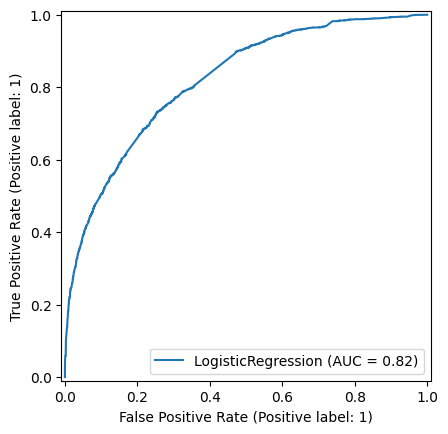

In [ ]:
curva_roc(lr, X_test_, y_test)

## Log Regression con columnas 'text' y 'title' y clasificación binaria

Ahora lo que podemos hacer es combinar las dos columnas de 'train' y 'test' para ver si obtenemos mejores resultados. Utilizamos inicialmente la clasificación binaria.

Comprobamos que contamos con el dataset apropiado, y sus 30.000 filas.

In [ ]:
df_beauty_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title_lemmatized  30000 non-null  object 
 1   text_lemmatized   30000 non-null  object 
 2   rating            30000 non-null  float64
 3   sentiment_label   30000 non-null  int64  
 4   rating_str        30000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


Se trata pues de hacer una fusión de columnas, o más bien de sus vectorizaciones. Lo cierto es que en este caso he tenido que recurrir a la inteligencia artificial (DeepSeek), que tras varios intentos, conseguí hacer funcionar.

El primer paso consiste en crear una transformación de las dos columnas, instanciando para cada una de ellas la vectorización, en este caso con distinto número máximo de palabras.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('title_tfidf', TfidfVectorizer(max_features=1500, ngram_range=(1, 2)), 'title_lemmatized'),
        ('text_tfidf', TfidfVectorizer(max_features=2500, ngram_range=(1, 2)), 'text_lemmatized')
    ]
)

Ahora definimos una pipeline, que relaciona la transformación de columnas con el modelo de clasificación, la regresión logística, que por defecto supone un C de 1.

In [ ]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

Ahora definimos los datasets, que en el caso de X son las dos columnas que queremos combinar, 'title' y 'text'.

In [ ]:
X = df_beauty_prep[['title_lemmatized', 'text_lemmatized']]
y = df_beauty_prep['sentiment_label']

Y ahora hacemos el train text split, como en casos anteriores.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [ ]:
X_train.shape

(24000, 2)

In [ ]:
y_train.shape

(24000,)

Lo que queda es entrenar el pipeline...

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('title_tfidf',
                                                  TfidfVectorizer(max_features=1500,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'title_lemmatized'),
                                                 ('text_tfidf',
                                                  TfidfVectorizer(max_features=2500,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'text_lemmatized')])),
                ('classifier', LogisticRegression())])

... y hacer el predict con el X_test, que, de nuevo, supone un C de 1 en la regresión logística.

In [ ]:
test_predict = pipeline.predict(X_test)

Ahora podemos ver los resultados, que pensamos que son basante buenos, ya que vemos que el accuracy sube al 0.83, frente al 0.8 que obtuvimos con la columna 'text' en solitario. Además, hemos elevado al 0.76 el recall de la clase minoritaria, otra mejora.

Por lo tanto, vemos que la suma de la información de ambas columnas sí que es relevante, al menos en el caso de los clasificadores de machine learning.

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[3092  440]
 [ 593 1875]]

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3532
           1       0.81      0.76      0.78      2468

    accuracy                           0.83      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.83      0.83      0.83      6000

Accuracy score:0.8278333333333333


En este caso, la curva ROC también mejora hasta el 0.91, frente a 0.86 anterior.

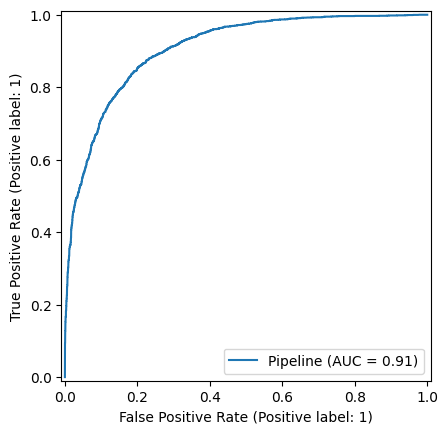

In [ ]:
curva_roc(pipeline, X_test, y_test)

Hemos visto el caso del coeficiente C de 1, pero podemos buscar el óptimo. De todas formas, vemos que efectivamente, el mejor C es el 1.

In [ ]:
c_params = [0.01, 0.1, 0.5, 1, 3, 5, 10]

train_acc = list()
test_acc = list()
for c in c_params:

  pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C = c))
])

  pipeline.fit(X_train, y_train)

  train_predict = pipeline.predict(X_train)
  test_predict = pipeline.predict(X_test)

  print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

  train_acc.append(accuracy_score(y_train, train_predict))
  test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.7088333333333333
Accuracy for C=0.1: 0.8093333333333333
Accuracy for C=0.5: 0.8253333333333334
Accuracy for C=1: 0.8278333333333333
Accuracy for C=3: 0.8218333333333333
Accuracy for C=5: 0.8206666666666667
Accuracy for C=10: 0.8155


## Log Regression con columnas 'text' y 'title' y clasificación 1 a 5

Ahora podemos ver el caso de clasificación de rating entre 1 y 5, combinando ambas columnas. El proceso es en realidad el mismo, solo que ahora la columna de y es la 'rating_str'.

In [ ]:
X = df_beauty_prep[['title_lemmatized', 'text_lemmatized']]
y = df_beauty_prep['rating_str']

Hacemos otra vez la división train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

Probamos ahora varios coeficientes C, definiendo el pipeline cada vez. En este caso el máximo de iteraciones lo hemos subido a 1.000, pues con 500 sencillamente el modelo no convergía.

En este caso obtenemos unos accuracies en el entorno del 0.54, algo mejores de nuevo al caso de 'text.

In [ ]:
c_params = [0.01, 0.1, 0.5, 1, 3, 5, 10]

train_acc = list()
test_acc = list()
for c in c_params:

  pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C = c, max_iter = 1000))
])

  pipeline.fit(X_train, y_train)

  train_predict = pipeline.predict(X_train)
  test_predict = pipeline.predict(X_test)

  print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

  train_acc.append(accuracy_score(y_train, train_predict))
  test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.479
Accuracy for C=0.1: 0.5391666666666667
Accuracy for C=0.5: 0.541
Accuracy for C=1: 0.5363333333333333
Accuracy for C=3: 0.5151666666666667
Accuracy for C=5: 0.5038333333333334
Accuracy for C=10: 0.4935


finalmente nos hemos quedado con un C de 0.1, pese a no ser en teoría el óptimo, para eliminar el overfitting.

In [ ]:
c = 0.1

pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('classifier', LogisticRegression(C = c, max_iter = 1000))
])

pipeline.fit(X_train, y_train)

train_predict = pipeline.predict(X_train)
test_predict = pipeline.predict(X_test)

print ("Train Accuracy for C={}: {}".format(c, accuracy_score(y_train, train_predict)))

print ("Test Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

Train Accuracy for C=0.1: 0.5912083333333333
Test Accuracy for C=0.1: 0.5391666666666667


Las métricas son algo mejores, pero cualitativamente siguen teniendo el mismo problema: los recalls de las clases intermedias son muy pequeñas. Lo cierto es que ese era el caso en ambos datasets, y la mejora ahora no es apenas relevante.

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{:.3}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[1547    3   50   85   45]
 [ 493    4   88  101   52]
 [ 338    8  225  266   96]
 [ 201    1  115  648  388]
 [ 137    0   22  276  811]]

Classification report:
              precision    recall  f1-score   support

         1.0       0.57      0.89      0.70      1730
         2.0       0.25      0.01      0.01       738
         3.0       0.45      0.24      0.31       933
         4.0       0.47      0.48      0.47      1353
         5.0       0.58      0.65      0.61      1246

    accuracy                           0.54      6000
   macro avg       0.46      0.45      0.42      6000
weighted avg       0.49      0.54      0.49      6000

Accuracy score:0.539


## **Modelos de deep learning**

Pasamos ahora a los modelos de deep learning. Nos hemos centrado en calcular nosotros mismos la capa de embedding, y estimar modelos de clasificación binaria con las columnas de 'text' y 'title' por separado y conjuntamente.

## Embeddings estimados con columna 'text' y clasificación binaria

Comenzamos con la columna de 'text' de las reviews, y llevamos a cabo la división de train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_beauty_prep['text_lemmatized'],
    df_beauty_prep['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Ya que queremos determinar nuestra capa de embedding, utilizando naturalmente Word2Vec, con los parámetros siguientes de esta librería, integrada a su vez dentro de gensim.

In [ ]:
# Parámetros del WORD2VEC
W2V_SIZE = 300 # tamaño de vectores
W2V_WINDOW = 7 # número de palabras que va a mirar alrededor
# 32
W2V_EPOCH = 5 # número de epoca
W2V_MIN_COUNT = 2 #número mínimo de frecuencia

# KERAS
SEQUENCE_LENGTH = 500 # número de secuencias de keras

Ahora utilizamos las tres funciones que ya vimos en clase, aunque hubo que modificaras ligeramente, porque lo que tenemos ahora no son datasets, sino lo que python considera una 'series'.

Por lo tanto, aquí tenemos el tokenizador...

In [ ]:
def generate_tokenizer(train_df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df)
    vocab_size = len(tokenizer.word_index) + 1
    print(f"Total words: {vocab_size}")
    return tokenizer, vocab_size

... así como el word2vec, que incluye los tres pasos imprescindibles: el vocabulario, la instanciación del modelo, y su entrenamiento.

In [ ]:
def generate_word2vec(train_df):
    documents = [_text.split() for _text in train_df]
    w2v_model = gensim.models.word2vec.Word2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT,
        workers=mp.cpu_count(),
    )
    w2v_model.build_vocab(documents)

    words = w2v_model.wv.key_to_index.keys() # Corrected line
    vocab_size = len(words)
    print(f"Vocab size: {vocab_size}")
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

    return w2v_model

Finalmente tenemos la función de la propia generación de la capa de embedding.

In [ ]:
# Generamos la capa de embeddings

def generate_embedding(word2vec_model, vocab_size, tokenizer):
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return Embedding(
        vocab_size,
        W2V_SIZE,
        weights=[embedding_matrix],
        input_length=SEQUENCE_LENGTH,
        trainable=False,
    )



Esta es la prueba que tenemos una series, al haber seleccionado solo una columna. Tampoco es importante.

In [ ]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 22500 entries, 21177 to 23654
Series name: text_lemmatized
Non-Null Count  Dtype 
--------------  ----- 
22500 non-null  object
dtypes: object(1)
memory usage: 351.6+ KB


In [ ]:
X_train.head()

,text_lemmatized
21177,make hair soft
23942,cheap having pay premium high end salon produc...
1247,do not hold hair clip thin hair work
23622,great price professional packaging come free g...
28454,take three coat color coverage take long time ...


Ahora ya podemos ejecutar las funciones. Comenzamos por el tokenizador, que nos informa de que tenemos 16 mil palabras.

In [ ]:
tokenizer, vocab = generate_tokenizer(X_train)

Total words: 16397


Ahora generamos el modelo de word2vec, con X_train, que tenemos un vocabulario de unos 7.800 palabras.

In [ ]:
word2vec_model = generate_word2vec(X_train)

Vocab size: 7797


Ahora pasamos a examinar el asunto del padding, o más bien los parámetros de las neuronas de la capa LSTM.

In [ ]:
from tensorflow.keras.utils import pad_sequences

tenemos que tener en cuenta el tamaño de las filas en la columna 'text'. Para ello, creamos una columna con el tamaño de cada fila.

In [ ]:
df_beauty_prep['len'] = df_beauty_prep['text_lemmatized'].apply(lambda x: len(x.split()))

Hacemos un describe() de esta columna, que tiene como media 16 palabras. Pienso que, de todas formas conviene poner algo más, sin llegar desde luego al máximo, en lo que es un comprimiso entre el ruido de los ceros del padding, y la pérdida de información de las filas de mayor tamaño.

In [ ]:
df_beauty_prep['len'].describe()

,len
count,30000.000000
mean,16.035500
std,21.417255
min,1.000000
25%,5.000000
50%,10.000000
75%,19.000000
max,733.000000


Tomamos así un número de palabras de 40, y calculamos los paddings de train y test.

In [ ]:
max_words = 40

X_train_words = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_words)
X_test_words = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_words)

No se nos olvida calcular finalmente la capa de embedding.

In [ ]:
# import numpy as np
embedding_layer = generate_embedding(word2vec_model, vocab, tokenizer)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Ahora ya podemos definir el modelo sequencial, con nuestra capa de embedding, otra de LSTM de dimensión 100, y finalmente una capa densa para hallar la clasificación binaria. Tenemos cerca de 5 millones de parámetros a determinar.

In [ ]:
model_custom = Sequential()
#pasamos directamente la capa que hemos generado
model_custom.add(embedding_layer)
model_custom.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_custom.add(Dense(1, activation="sigmoid"))

In [ ]:
model_custom.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,919,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,919,100 (18.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,919,100 (18.76 MB)

Pasamos a compilar el modelo, con el optimizador Adam.

In [ ]:
model_custom.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Y finalmente hacemos el entrenador del modelo, con un tamaño de batch de 64 y 10 épocas. He utilizado la CPU, no siendo necesario la GPU, o no demasiado.

Hallamos una accuracy en train de 0.80, lo cual es la misma en la práctica que con la regresión logística, no siendo pues una diferencia muy relevante, la verdad.

In [ ]:
batch_size = 64
num_epochs = 10

X_train_words_valid, y_valid = X_train_words[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train_words2, y_train2 = X_train_words[batch_size:], y_train[batch_size:]  # rest for training

model_custom.fit(X_train_words2, y_train2,
          validation_data=(X_train_words_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.7140 - loss: 0.5538 - val_accuracy: 0.7812 - val_loss: 0.4819
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - accuracy: 0.7492 - loss: 0.4993 - val_accuracy: 0.8125 - val_loss: 0.4231
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.7592 - loss: 0.4864 - val_accuracy: 0.7656 - val_loss: 0.3858
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 52s 147ms/step - accuracy: 0.7651 - loss: 0.4783 - val_accuracy: 0.7812 - val_loss: 0.3765
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - accuracy: 0.7733 - loss: 0.4615 - val_accuracy: 0.7812 - val_loss: 0.3434
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 55s 156ms/step - accuracy: 0.7775 - loss: 0.4589 - val_accuracy: 0.8281 - val_loss: 0.3240
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.7825 - loss: 0.4478 - val_accuracy: 0.8125 - val_loss: 0.3552
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 53s 152ms/step - accuracy: 0.7888 - loss: 0

Si evaluamos el dataset de test, el accuracy es de 0.77, en este caso ligeramente por debajo de lo obtenido con la regresión logística.

In [ ]:
scores = model_custom.evaluate(X_test_words, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.7728000283241272


Calculamos los outputs del modelo, y las métricas con los datasets de test. Vemos que en este caso el recall de la clase minoritaria es bastante bajo, inferior al 0.65. No es muy buen resultado, a mi juicio.

In [ ]:
test_predict = model_custom.predict(X_test_words)
test_predict = np.where(test_predict > 0.5, 1, 0)

235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step


In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{:.3}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[3894  507]
 [1197 1902]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.82      4401
           1       0.79      0.61      0.69      3099

    accuracy                           0.77      7500
   macro avg       0.78      0.75      0.76      7500
weighted avg       0.78      0.77      0.77      7500

Accuracy score:0.773


Por lo tanto, en principio no parece que este modelo suponga una clara mejora, aunque está por ver lo bien que hallamos podido determinar los parámetros.

## Embeddings estimados con columna 'title' y clasificación binaria

Ahora repetimos el mismo proceso con la columna de 'title'. El proceso es el mismo, comenzando con la división de train y test.

In [ ]:
X_train_title, X_test_title, y_train, y_test = train_test_split(
    df_beauty_prep['title_lemmatized'],
    df_beauty_prep['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Aplicamos las funciones de tokenización y vord2vec, que vemos que nos informan que el tamaño de palabras y diccionario son menores, lo cual era de esperar.

In [ ]:
tokenizer_tl, vocab_tl = generate_tokenizer(X_train_title)

Total words: 5255


In [ ]:
word2vec_model_tl = generate_word2vec(X_train_title)

Vocab size: 2453


Vamos con el padding, que seguimos el mismo proceso. En este caso, la longitud media es de menos de 3 palabras.

In [ ]:
df_beauty_prep['len'] = df_beauty_prep['title_lemmatized'].apply(lambda x: len(x.split()))

In [ ]:
df_beauty_prep['len'].describe()

,len
count,30000.000000
mean,2.451800
std,1.695515
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,19.000000


Tomamos un tamaño máximo de 12 palabras y calculamos los paddings de train y test.

In [ ]:
max_words = 12

X_train_words_tl = pad_sequences(tokenizer_tl.texts_to_sequences(X_train_title), maxlen=max_words)
X_test_words_tl = pad_sequences(tokenizer_tl.texts_to_sequences(X_test_title), maxlen=max_words)

La capa de embedding le determinamos a continuación.

In [ ]:
embedding_layer_tl = generate_embedding(word2vec_model_tl, vocab_tl, tokenizer_tl)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Ahora creamos el modelo, con la capa de embedding que hemos encontrado en el caso de la columna 'title'. No cambiamos el resto de parámetros o capas.

In [ ]:
model_custom_tl = Sequential()
#pasamos directamente la capa que hemos generado
model_custom_tl.add(embedding_layer_tl)
model_custom_tl.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_custom_tl.add(Dense(1, activation="sigmoid"))

Compilamos el modelo de la misma forma.

In [ ]:
model_custom_tl.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Y ahora hacemos el entrenamiento del mismo modelo que en el caso anterior, en este caso con 7 épocas. El fit en train es de 0.65, bastante inferior al de la regresión logística, de 0.74.

In [ ]:
batch_size = 64
num_epochs = 7

X_train_words_valid, y_valid = X_train_words_tl[:batch_size], y_train[:batch_size]  # first batch_size samples
X_train_words2, y_train2 = X_train_words_tl[batch_size:], y_train[batch_size:]  # rest for training

model_custom_tl.fit(X_train_words2, y_train2,
          validation_data=(X_train_words_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.6151 - loss: 0.6626 - val_accuracy: 0.7031 - val_loss: 0.6424
Epoch 2/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6471 - loss: 0.6348 - val_accuracy: 0.7188 - val_loss: 0.6545
Epoch 3/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6478 - loss: 0.6292 - val_accuracy: 0.6875 - val_loss: 0.6352
Epoch 4/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6532 - loss: 0.6273 - val_accuracy: 0.6875 - val_loss: 0.6259
Epoch 5/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6523 - loss: 0.6263 - val_accuracy: 0.6719 - val_loss: 0.6281
Epoch 6/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6527 - loss: 0.6228 - val_accuracy: 0.7031 - val_loss: 0.6181
Epoch 7/7
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6524 - loss: 0.6207 - val_accuracy: 0.6875 - val_loss: 0.6233


En el caso de test, el accuracy es de 0.64, de nuevo inferior al caso de la regresión logística.

In [ ]:
scores = model_custom_tl.evaluate(X_test_words_tl, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.6363999843597412


De nuevo hacemos el predict, y encontramos que el fallo reside en el recall de la clase minoritaria, que es de apenas el 0.2. El modelo pues no parece reconocerla. Malas noticias.

In [ ]:
test_predict = model_custom_tl.predict(X_test_words_tl)
test_predict = np.where(test_predict > 0.5, 1, 0)

235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{:.3}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[4148  253]
 [2474  625]]

Classification report:
              precision    recall  f1-score   support

           0       0.63      0.94      0.75      4401
           1       0.71      0.20      0.31      3099

    accuracy                           0.64      7500
   macro avg       0.67      0.57      0.53      7500
weighted avg       0.66      0.64      0.57      7500

Accuracy score:0.636


Tampoco ofrece grandes ventajas desde luego el modelo de deep learning en este caso, aunque, de nuevo, puede depender de la gran cantidad de parámetros que hemos asumido, y que no hemos hecho variaciones a ver cómo cambiaba el accuracy.

## Embeddings estimados con columna 'text' y 'title' y clasificación binaria

Finalmente, vemos el caso de combinación de las columnas 'text' y 'title'. Aquí de nuevo hemos pedido ayuda a DeepSeek, que de forma algo accidentada, hemos podido hacer funcionar.

In [ ]:
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.optimizers import Adam

Comenzamos con la definición de las capas de entrada, que coinciden en tamaño con los paddings de cada capa.

In [ ]:
# Define input layers
title_input = Input(shape=(12,), name='title_input')
text_input = Input(shape=(40,), name='text_input')

Ahora tomamos las capas de embedding de cada una de las columnas y las aplicamos el padding.

In [ ]:
# Apply respective embedding layers
title_embedding = embedding_layer_tl(title_input)  # Your pre-trained title embedding
text_embedding = embedding_layer(text_input)  # Your pre-trained text embedding

Ahora por separado las añadimos las capas respectivas de LSTM de 100 neuronas a cada una de las columnas, utilizando pues el paradigma funcional de Keras.

In [ ]:
# Process each input through separate LSTM layers
title_lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(title_embedding)
text_lstm = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(text_embedding)

Hacemos la concatenación de ambas capas LSTM en una sola...

In [ ]:
# Concatenate the LSTM outputs
concatenated = Concatenate()([title_lstm, text_lstm])

... a las que añadimos una capa densa de 64 neuronas, y finalmente la capa densa de determinación de la clase.

In [ ]:
# Add dense layers
dense1 = Dense(64, activation='relu')(concatenated)
dropout1 = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout1)

Ahora ya podemos definir el modelo, con las capas de input, y el output que acabamos de definir.

In [ ]:
# Create model
model_combined = Model(
    inputs=[title_input, text_input],
    outputs=output,
    name='combined_lstm_model'
)

Ahora compilamos el modelo con el optimizador de Adam, con un learning de 0.001. Tenemos pues casi 7 millones de parámetros a determinar.

In [ ]:
model_combined.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_combined.summary()

Model: "combined_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_input         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 300)   │  1,576,500 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 300)   │  4,919,100 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100)       │    160,400 │ embedding_2[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 100)       │    160,400 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     12,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,829,329 (26.05 MB)

 Trainable params: 333,729 (1.27 MB)

 Non-trainable params: 6,495,600 (24.78 MB)

Tenemos que concatenar en una lista los datos de train y test, con las columnas a los que hemos aplicado los padding correspondientes.

In [ ]:
# Training data format for multi-input model
train_data = [X_train_words_tl, X_train_words]
test_data = [X_test_words_tl, X_test_words]

Hacemos el entrenamiento del modelo. Ahora he considerado como validación los datasets de test.

Lo cierto es que los accuracy no son muy buenos dadas las circunstancias, ya que no mejoran los que vimos cuando usamos la columna de 'text', que se queda en el 0.79.

In [ ]:
history = model_combined.fit(
    train_data, y_train,
    batch_size = 32,
    epochs = 7,
    validation_data = (test_data, y_test),
    verbose = 1
)

Epoch 1/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 116s 153ms/step - accuracy: 0.7077 - loss: 0.5560 - val_accuracy: 0.7525 - val_loss: 0.4925
Epoch 2/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 136s 145ms/step - accuracy: 0.7625 - loss: 0.4893 - val_accuracy: 0.7683 - val_loss: 0.4687
Epoch 3/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 138s 139ms/step - accuracy: 0.7694 - loss: 0.4756 - val_accuracy: 0.7773 - val_loss: 0.4608
Epoch 4/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 100s 142ms/step - accuracy: 0.7820 - loss: 0.4614 - val_accuracy: 0.7813 - val_loss: 0.4482
Epoch 5/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 143s 144ms/step - accuracy: 0.7876 - loss: 0.4465 - val_accuracy: 0.7863 - val_loss: 0.4486
Epoch 6/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 167s 179ms/step - accuracy: 0.7892 - loss: 0.4432 - val_accuracy: 0.7851 - val_loss: 0.4479
Epoch 7/7
704/704 ━━━━━━━━━━━━━━━━━━━━ 148s 187ms/step - accuracy: 0.7936 - loss: 0.4319 - val_accuracy: 0.7797 - val_loss: 0.4471


En el caso del dataset de test el accuracy se queda en el 0.78, nada espectacular tampoco.

In [ ]:
scores = model_combined.evaluate(test_data, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.7797333598136902


In [ ]:
test_predict = model_combined.predict(test_data)
test_predict = np.where(test_predict > 0.5, 1, 0)

235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step


Sin embargo, sí que tenemos mejores noticias en el caso de los recalls, pues mejoran claramente en el caso de la clase minoritaria, que se iguala prácticamente a la mayoritaria en el 0.8. Por lo tanto, si bien el accuracy no aumenta, la calidad del modelo pienso que es bastante mejor cuando combinamos ambas columnas.

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{:.3}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[3455  946]
 [ 706 2393]]

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4401
           1       0.72      0.77      0.74      3099

    accuracy                           0.78      7500
   macro avg       0.77      0.78      0.78      7500
weighted avg       0.78      0.78      0.78      7500

Accuracy score:0.78


# **Modelo preentrenado**

## Modelo BERT de clasificación de sentimientos

Finalmente, vamos a utilizar un modelo preentrenado, que hemos bajado de Hugging Face, el 'nlptown/bert-base-multilingual-uncased-sentiment', [link](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment)

Para ello seguimos las instrucciones del link, que permiten copiar el código.

De esta forma descargamos las librerías necesarias, y bajamos el tokenizador y el modelo como tal.

In [ ]:
!pip install -U transformers

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Ahora hemos tenido que conectar la GPU de Colab, T4, con lo que cargamos estrictamente las librerías que necesitamos, entre ellas pandas.

In [ ]:
import pandas as pd

BERT requiere que el texto sea el original, sin ser preprocesado, así que cargamos el dataset sin preprocesamiento de las review de belleza. Aplicamos el casteo a string, como de costumbre.

In [ ]:
dtype = {'text': str, 'title': str}

df_beauty_balanced = pd.read_csv('/content/drive/MyDrive/Practica_NLP_25/Project/df_beauty_balanced.csv', dtype = dtype, na_values = '')

In [ ]:
df_beauty_balanced['title'] = df_beauty_balanced['title'].astype(str)
df_beauty_balanced['text'] = df_beauty_balanced['text'].astype(str)

In [ ]:
df_beauty_balanced = df_beauty_balanced.sample(30000, random_state = 26)

In [ ]:
df_beauty_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   30000 non-null  object 
 1   text    30000 non-null  object 
 2   rating  30000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 703.3+ KB


Un aspecto importante es que este modelo de BERT viene entrenado con ratings de sentimientos de 0 a 4, mientras que nosotros tenemos ratings de 1 a 5; habrá que tener eso en cuenta después.

Por el momento hacemos el train test split.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_beauty_balanced['text'],
    df_beauty_balanced['rating'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Para la aplicación del modelo hemos seguido lo que nos recomendaba DeepSeek, que reconozco que ha sido decisivo, con algunas correcciones que he tenido que hacer. Lo cierto es que me ha recomendado utilizar Torch, y no Keras.

In [ ]:
import torch
import numpy as np

Cargamos las librerías de las métricas más comunes.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Ya que el tiempo de ejecución podía ser largo, cargamos la librería de seguimiento de ejecución tqdm.

In [ ]:
from tqdm.auto import tqdm

A continuación tenemos la función que nos recomendó DeepSeek, que, como dijimos, utiliza Torch. No es demasiado complicada, básicamente recibe los textos en batches, aplica el tokenizador y hace las predicciones. Al tratarse de Torch, tiene como costumbre guardar la información en la GPU.

In [ ]:
def predict_sentiment_batch(texts, model, tokenizer, batch_size=16):
    """Predict sentiment in batches with progress bar"""
    predictions = []

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Process in batches with progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]

        # Tokenize batch
        inputs = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Move to GPU
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Predict
        with torch.no_grad():
            outputs = model(**inputs)
            batch_predictions = torch.argmax(outputs.logits, dim=1)
            predictions.extend(batch_predictions.cpu().tolist())

    return predictions


También tenemos un conversor de los rating de 0 a 4, en formato BERT, a la clasificación binaria que hemos venido utilizando.

In [ ]:
def convert_to_binary(predictions):
    binary_predictions = []
    for pred in predictions:
        if pred in [0, 1]:  # 1-2 stars (assuming 0-indexed: 0=1 star, 1=2 stars)
            binary_predictions.append(1)  #
        elif pred in [2, 3, 4]:  #
            binary_predictions.append(0)  #
       # else:  # 3 stars (2=3 stars)
         #   binary_predictions.append(1)  # Or you can exclude these
    return binary_predictions

Y ahora solo queda el ejecutar a función, enviando el modelo, el tokenizador, y el tamaño de batch, que DeepSeek recomienda que sea de 32 filas. El tiempo de ejecución al final no es excesivo, pero en un primer intento, sin fijar el batch, se eternizaba.

In [ ]:
print("Processing training set...")
train_predictions = predict_sentiment_batch(X_train.tolist(), model, tokenizer, batch_size=32)

print("Processing test set...")
test_predictions = predict_sentiment_batch(X_test.tolist(), model, tokenizer, batch_size=32)

Processing training set...


Processing batches:   0%|          | 0/704 [00:00<?, ?it/s]

Processing test set...


Processing batches:   0%|          | 0/235 [00:00<?, ?it/s]

Ya tenemos las predicciones, y ahora hay que compararlas con las presentes en y_train e y_test, ajustando las predicciones al formato 1-5 frente al 0-4.

Lo cierto es que el accuracy no es tan alto, cerca del 60%, pero lo que es notable es que los recalls de las clases intermedias, en el entorno del 50%, son mucho má altos que en los modelos que hemos entrenado anteriormente. Es un resultado muy notable.

In [ ]:
# Evaluate
print("Train Accuracy:", accuracy_score(y_train, list(np.array(train_predictions) + 1)))
print("Test Accuracy:", accuracy_score(y_test, list(np.array(test_predictions) + 1)))
print("\nClassification Report:")
print(classification_report(y_test, list(np.array(test_predictions) + 1)))

Train Accuracy: 0.5872444444444445
Test Accuracy: 0.5862666666666667

Classification Report:
              precision    recall  f1-score   support

         1.0       0.80      0.65      0.72      2158
         2.0       0.30      0.48      0.37       941
         3.0       0.45      0.49      0.47      1161
         4.0       0.61      0.46      0.53      1673
         5.0       0.69      0.77      0.73      1567

    accuracy                           0.59      7500
   macro avg       0.57      0.57      0.56      7500
weighted avg       0.62      0.59      0.59      7500



Si vemos la matriz de confusión comprobamos la potencia del modelo, pues los errores tienden a ser siempre por estimarse las clases adyecentes. Muy bien!

In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, list(np.array(test_predictions) + 1))))

Confussion matrix:
[[1401  606   99   28   24]
 [ 249  450  197   29   16]
 [  72  315  566  156   52]
 [  18   84  355  771  445]
 [  15   21   51  271 1209]]


Por último, podemos ver el caso de la clasificación binaria, para lo cual traducimos las estimaciones del modelo así como los datasets de train y test.

In [ ]:
# Convert to binary
train_binary_pred = convert_to_binary(train_predictions)
test_binary_pred = convert_to_binary(test_predictions)

In [ ]:
def label_sentiment(row):
    if int(row['rating']) < 3:
        return 1
    else:
        return 0

In [ ]:
y_train_binary = y_train.astype(int).apply(lambda rating_value: 1 if rating_value < 3 else 0)
y_test_binary = y_test.astype(int).apply(lambda rating_value: 1 if rating_value < 3 else 0)

Los resultados son excelentes, porque no solo el accuracy es cercano al 90%, sino que también lo son los recalls de ambas clases. Un resultado impresionante, la verdad.

In [ ]:
print("Train Accuracy:", accuracy_score(y_train_binary, train_binary_pred))
print("Test Accuracy:", accuracy_score(y_test_binary, test_binary_pred))
print("\nClassification Report:")
print(classification_report(y_test_binary, test_binary_pred))

Train Accuracy: 0.8678666666666667
Test Accuracy: 0.8776

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4401
           1       0.84      0.87      0.85      3099

    accuracy                           0.88      7500
   macro avg       0.87      0.88      0.87      7500
weighted avg       0.88      0.88      0.88      7500



In [ ]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test_binary, test_binary_pred)))

Confussion matrix:
[[3876  525]
 [ 393 2706]]


# **Conclusiones**

Hay una serie de conclusiones que pienso que es necesario destacar:

**Visualización**
- La gráfica de Chi2 es más importante de lo esperado para controlar la eliminación de las stopwords en el procesado; hay serio riesgo de eliminar palabras realmente importantes.
- La vectorización TFIDF y los embeddings da una imagen bastante clara y útil de la estructura del vocabulario antes incluso del preprocesado.
- Otras visualizaciones como el Wordcloud ponen de manifiesto aspectos en los que incidir en el preprocesado como la eliminación de código html.

**Preprcesado**
- Hay que tener mucho cuidado con los stopword, porque existen librerías incluyen una lista demasiado amplia, especialmente de palabras que serán siempre relavantes en la clasificación de sentimientos; el que la lista de SpaCy tenga apenas 326 palabras es buena muestra de ello.
- Librerías como BeautifulSoup, quizás no concebidas con este propósito, son útiles para limpieza de código html en el preprocesado.
- No tengo claro la utilidad de la lemmatización a partir al menos de esta práctica; desde luego existe por alguna razón, pero su impacto como paso final en el preprocesado parece limitado, en especial para el esfuerzo computacional que implica.

**Modelado**
- Dentro de los algoritmos de Machine Learning, uno de los más simples, como es la regresión logística, parece dar buenos resultados, especialmente con niveles de regularización pequeños.
- Algoritmos más soficticados como random forest no superan a la regresion logística, y corren serio riesgo de overfitting.
- Con todo, ninguno de los algoritmos son capaces de distinguir las clases minoritarias centrales (2 y 3 estrellas), mostrando unos recalls muy bajos.
- Los accuracies altos en la clasificación binaria pienso que se deben a la concentración del vocabulario más explícito en las clases extremas.
- La fusión de las columnas de texto de la review y el título aporta mejoras no decisivos pero sí relevantes.
- En los modelos de deep learning encontramos que calcular las capas de embedding no fue demasiado complicado.
- Los resultados de estos modelos, en cambio, no mejoraron de forma relavante, o casi en absoluto los de machine learning, aunque es cierto que es posible que no hayamos exprimido las posibilidades de variar parametros para optimizar su rendimiento.
- El modelo preentrenado de BERT da unos resultados muy buenos, en especial teniendo en cuenta la clasificación multiclase.

**Aspectos a explorar**
- Teniendo en cuenta la amplitud de la vectorización TFIDF de 2.500 columnas, es probable que los modelos al menos de ML se beneficien de aplizar PCA, quizás en especial random forest y los relacionados con árboles.
- Se podrían aplicar redes neuronales lineales en vez de algorítmos clásicos de machine learning.
- Se pueden explorar los parámetros de los modelos de deep learning, no solo la estructura de las redes, sino también incluyendo la defición de los embeddings.
- Se podría intentar correlacionar la longitud de los textos y títulos con los ratings para mejorar de alguna forma los recalls de las clases minoritarias, es una idea.